# Neural networks as classifiers

As a basic example of the use of Neural Networks, we use Keras to build a classifier of a two-class sample. 

In [1]:
# Set up imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

## Generate test dataset

Use `make_classification` to generate a random dataset. From `sklearn` reference manual:

`This initially creates clusters of points normally distributed (std=1) about vertices of an n_informative-dimensional hypercube with sides of length 2*class_sep and assigns an equal number of clusters to each class. It introduces interdependence between these features and adds various types of further noise to the data.`

You can play with the different arguments:

* Set `n_classes` to 2 so we get a binary problem __(if you want to change this you will have to adapt the notebook)__
* Set the value of `class_sep` to lower or higher values to make the task of the classifier harder or easier. 
* `n_samples` gives the number of objects generated
* Changing the number of features will also affect the behaviour of the classifier.

Suggestion: vary `class_sep` from 0.1 to 2.

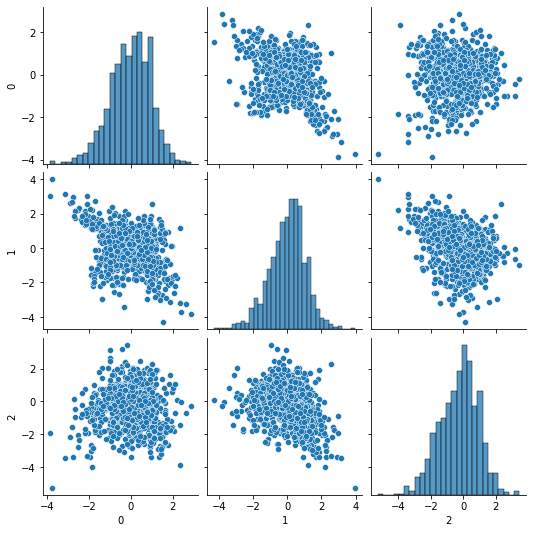

In [2]:
# generate 2 class dataset
# X contains the object data and y the object classification (0 or 1)
X, y = make_classification(n_samples=1000, \
                           n_classes=2, class_sep=.5, \
                           n_features=3,\
                           n_informative=3, n_redundant=0,\
                           n_repeated=0, random_state=2)

# Create a pairplot
df = pd.DataFrame(X)
sns.pairplot(df)
p= plt.show()

Now split sample into train and test subsets. You can play with the train-test percentage split (`test_size`, initially 40%). 

Plot two parameters for train and test to visualize the split.

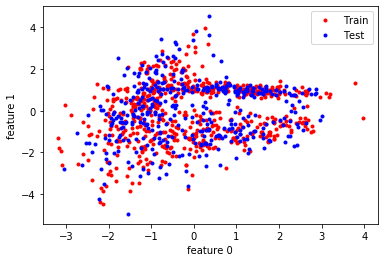

In [6]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.4, random_state=2)

plt.plot(trainX[:,0],trainX[:,1],"r.",label="Train")
plt.plot(testX[:,0],testX[:,1],"b.",label="Test")
plt.xlabel("feature 0")
plt.ylabel("feature 1")
plt.legend()
p= plt.show()

## Set up the Neural Network with Keras

The example below features a simple sequential (perceptron-type) Neural Network with:

* Input layer with three neurons (`input_dim`), corresponding to the 3 features of the generated dataset
* One hidden layer with 5 neurons
* Output layer with one neuron

You can change it to include more neurons and layers.

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(10)
my_NN = Sequential() # create model

# First layer, set the input_dim to the number of parameters
my_NN.add(Dense(5, input_dim=3, activation='relu')) # hidden layer

# You can add more hidden layers here
# my_NN.add(Dense(5, activation='relu')) # hidden layer

# Output layer
my_NN.add(Dense(1, activation='sigmoid')) # output layer

# Compile and define the loss function
my_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the network

In [8]:
# verbose=0 suppresses the file writing message
my_NN_fitted = my_NN.fit(trainX, trainy, epochs=1000, verbose=0, batch_size=trainX.shape[0],
                         initial_epoch=0)

Seee how the accuracy has evolved with the training:

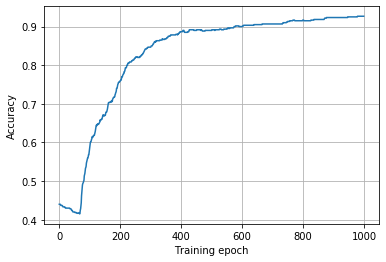

In [9]:
plt.plot(my_NN_fitted.history['accuracy'])
plt.xlabel("Training epoch")
plt.ylabel("Accuracy")
plt.grid()
p= plt.show()


## Performance

Evaluate the performance using the test sample:

* accuracy = $\frac{True Pos + True Neg}{Total objects}$

In [10]:
perf= my_NN.evaluate(testX, testy, verbose=0)
# print(my_first_nn.metrics_names[0],"     ", perf[0])
print(my_NN.metrics_names[1]," ", perf[1])

accuracy   0.9300000071525574


## Analyze the Neural Network output

First, compare the histogram of the output for each class of objects

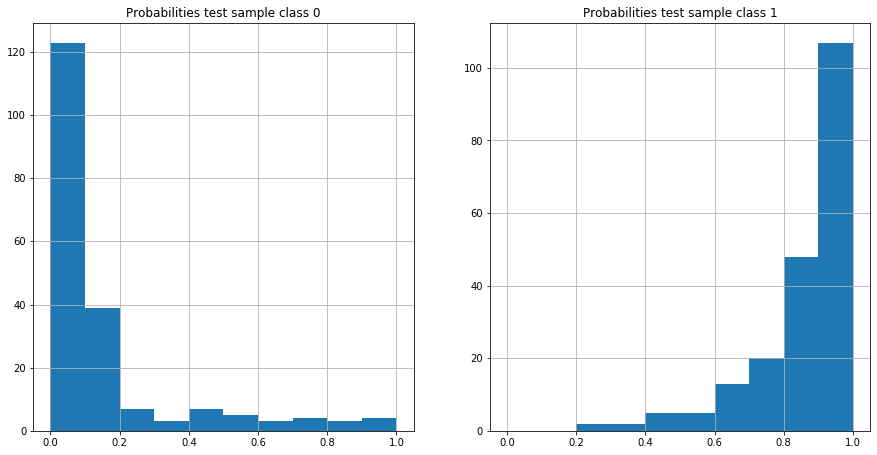

In [11]:
NN_out= my_NN.predict(testX, verbose=0)

# Separate output for each class of objects
out_class_0= [P[0] for P,obj_class in zip(NN_out,testy) if obj_class==0]
out_class_1= [P[0] for P,obj_class in zip(NN_out,testy) if obj_class==1]

fig = plt.figure(frameon=False)
fig.set_size_inches(15,7.5)
plt.xlabel("P")
plt.ylabel("N")

plt.subplot(1,2,1)
plt.hist(out_class_0, range=(0,1))
plt.grid(True)
plt.title("Probabilities test sample class 0")

plt.subplot(1,2,2)
plt.hist(out_class_1, range=(0,1))
plt.grid(True)
plt.title("Probabilities test sample class 1")

p= plt.show()

Next, interpreting the output as a probability, plot the ROC curve of the NN as a classifier.

NN AUC=0.975


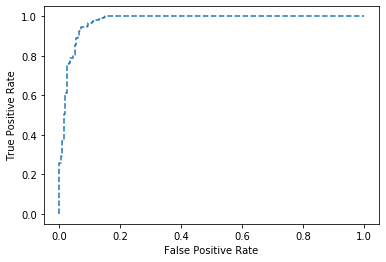

In [12]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

nn_probs= out_class_0= [P[0] for P in NN_out]

# calculate scores
nn_auc = roc_auc_score(testy, nn_probs)

# summarize scores
print('NN AUC=%.3f' % (nn_auc))

# calculate roc curves
nn_fpr, nn_tpr, _ = roc_curve(testy, nn_probs)

# plot the roc curve for the model
plt.plot(nn_fpr, nn_tpr, linestyle='--', label='NN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.legend()
plt.show()

## Learning curves

Now we repeat the fitting, collecting the results at several intermediate steps to build the learning curves for the training and test sets.

Redefine the network

In [21]:
import keras
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(10)
my_NN = Sequential() # create model

# First layer, set the input_dim to the number of parameters
my_NN.add(Dense(5, input_dim=3, activation='relu')) # hidden layer

# You can add more hidden layers here
# my_NN.add(Dense(5, activation='relu')) # hidden layer

# Output layer
my_NN.add(Dense(1, activation='sigmoid')) # output layer

# Compile and define the loss function
my_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Train in steps of 50 epochs and collect intermediate information

In [22]:
train_loss= []
train_acc= []
test_loss= []
test_acc= []

for step in range(200):
    
    # verbose=0 suppresses the file writing message
    my_NN_fitted = my_NN.fit(trainX, trainy, epochs=50, 
                             verbose=0, batch_size=trainX.shape[0])
    
    # Collect performance information for train and test
    perf= my_NN.evaluate(trainX, trainy, verbose=0)
    train_loss.append(perf[0])
    train_acc.append(perf[1])
    
    perf= my_NN.evaluate(testX, testy, verbose=0)
    test_loss.append(perf[0])
    test_acc.append(perf[1])


Plot curves

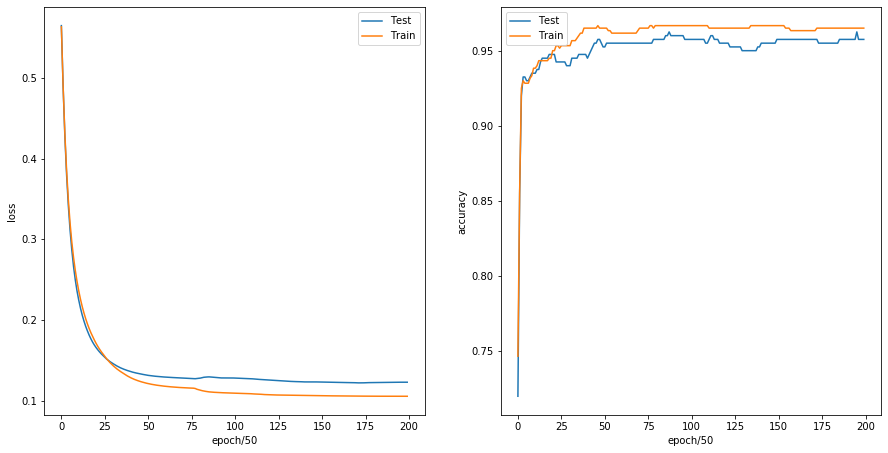

In [23]:
fig = plt.figure(frameon=False)
fig.set_size_inches(15,7.5)

# loss
plt.subplot(1,2,1)
plt.xlabel("epoch/50")
plt.ylabel("loss")
plt.plot(test_loss, label="Test")
plt.plot(train_loss, label="Train")
plt.legend()

# accuracy
plt.subplot(1,2,2)
plt.xlabel("epoch/50")
plt.ylabel("accuracy")
plt.plot(test_acc, label="Test")
plt.plot(train_acc, label="Train")
plt.legend()

p= plt.show()